<h1 style="text-align: center;">Clustering Algorithms: K-means and DBSCAN</h1>
<h4 style="text-align: center;">Yu-Chun Lo (howard.lo@nlplab.cc)</h4>
<h4 style="text-align: center;">Edited: Aditya Wisnugraha Sugiyarto (20120019)</h4>

***

In this tutorial, we explore how *K-means* and *DBSCAN* works. Besides, we show several drawbacks of *K-means* and provide solutions for addressing those drawbacks, including cluster quality analysis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Data Mining/Praktikum 3/credit_card.csv')
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## K-means

### The Algorithm

1. Randomly choose $k$ centroids $C = \{c_1, c_2, \dots, c_k\}$ from the data points $X = \{x_1, x_2, \dots, x_n\} \in \mathbb{R}^D $.
2. For each data point $x_i$, find the nearest centroid $c_j$ as its corresponding cluster using *sum of squared distance* $ D(x_i, c_j) = \displaystyle\sum_{i=1}^{n}{\| x_i - c_j \|^2}$.
3. For each cluster, update its centroid by computing means value along the dimension of data points in the cluster.
4. Compute the displacement between the old and the new centroids and repeat steps 2 and 3 if the displacement is less than a threshold (converged).

In [3]:
# Start from importing necessary packages.
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.display import display
from sklearn import metrics # for evaluations
from sklearn.datasets import make_blobs, make_circles # for generating experimental data
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN

# make matplotlib plot inline (Only in Ipython).
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
df.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [5]:
del df['MINIMUM_PAYMENTS']
df.isna().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        1
PAYMENTS                            0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [6]:
df['CREDIT_LIMIT'].index[df['CREDIT_LIMIT'].apply(np.isnan)]

Int64Index([5203], dtype='int64')

In [7]:
df.fillna(method='bfill',inplace=True)

In [8]:
df.isna().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [9]:
#Define X as Data
X = df.iloc[:,1:].values
X

array([[4.09007490e+01, 8.18182000e-01, 9.54000000e+01, ...,
        2.01802084e+02, 0.00000000e+00, 1.20000000e+01],
       [3.20246742e+03, 9.09091000e-01, 0.00000000e+00, ...,
        4.10303260e+03, 2.22222000e-01, 1.20000000e+01],
       [2.49514886e+03, 1.00000000e+00, 7.73170000e+02, ...,
        6.22066742e+02, 0.00000000e+00, 1.20000000e+01],
       ...,
       [2.33986730e+01, 8.33333000e-01, 1.44400000e+02, ...,
        8.12707750e+01, 2.50000000e-01, 6.00000000e+00],
       [1.34575640e+01, 8.33333000e-01, 0.00000000e+00, ...,
        5.25499590e+01, 2.50000000e-01, 6.00000000e+00],
       [3.72708075e+02, 6.66667000e-01, 1.09325000e+03, ...,
        6.31654040e+01, 0.00000000e+00, 6.00000000e+00]])

In [10]:
""" K-means clustering algorithm.

Parameters
----------
n_init: int, optional, default: 10
        Number of time the k-means algorithm will be run with different
        centroid seeds. The final results will be the best output of
        n_init consecutive runs in terms of inertia.
        
init: {'k-means++', 'random', or ndarray, or a callable}, optional
        Method for initialization, default to 'k-means++'.
        
        'k-means++': selects initial cluster centers for k-mean
        clustering in a smart way to speed up convergence.
        
        'random': generate k centroids from a Gaussian with mean and
        variance estimated from the data.

tol: float, default: 1e-4
        Relative tolerance with regards to inertia to declare convergence
        tolerance is computed using `np.mean(np.var(X, axis=0)) * tol)`

"""

# Perform K-means on our data (Train centroids)
kmeans = KMeans(n_clusters=5,
                n_init=3,
                init='random',
                tol=1e-4, 
                random_state=170,
                verbose=True).fit(X)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 177177607272.00287
start iteration
done sorting
end inner loop
Iteration 1, inertia 162394053925.8307
start iteration
done sorting
end inner loop
Iteration 2, inertia 157392107851.24094
start iteration
done sorting
end inner loop
Iteration 3, inertia 153851330448.33487
start iteration
done sorting
end inner loop
Iteration 4, inertia 151383571192.9664
start iteration
done sorting
end inner loop
Iteration 5, inertia 149932150634.9579
start iteration
done sorting
end inner loop
Iteration 6, inertia 148981670881.28778
start iteration
done sorting
end inner loop
Iteration 7, inertia 148142301454.13348
start iteration
done sorting
end inner loop
Iteration 8, inertia 147789899413.93588
start iteration
done sorting
end inner loop
Iteration 9, inertia 147523056715.68948
start iteration
done sorting
end inner loop
Iteration 10, inertia 147324303168.37317
start iteration
done sorting
end inner loop
Iteration 

In [11]:
# Retrieve predictions and cluster centers (centroids).
display(kmeans.labels_)
display(kmeans.cluster_centers_)

array([1, 0, 2, ..., 1, 1, 1], dtype=int32)

array([[5.80741328e+03, 9.65659281e-01, 5.68580565e+02, 3.15677618e+02,
        2.53005160e+02, 5.67114389e+03, 3.07140139e-01, 1.34417863e-01,
        2.16944211e-01, 4.50523344e-01, 1.38381679e+01, 9.51755725e+00,
        9.13870923e+03, 4.29068489e+03, 3.35790611e-02, 1.15053435e+01],
       [7.69432477e+02, 8.49402868e-01, 4.84613648e+02, 2.31205663e+02,
        2.53716068e+02, 4.60039232e+02, 4.47479038e-01, 1.24636422e-01,
        3.45535734e-01, 1.08027956e-01, 2.25374878e+00, 9.19727361e+00,
        2.06373331e+03, 8.56194787e+02, 1.43859150e-01, 1.13569620e+01],
       [1.63308659e+03, 8.98828780e-01, 1.09437251e+03, 6.42013241e+02,
        4.52759880e+02, 8.00922288e+02, 5.42535361e-01, 2.77650350e-01,
        3.79360890e-01, 1.24117273e-01, 2.80066308e+00, 1.70911728e+01,
        6.15188688e+03, 1.68146237e+03, 1.73599857e-01, 1.17467882e+01],
       [5.04663904e+03, 9.04105559e-01, 1.25517194e+04, 8.97314892e+03,
        3.57880699e+03, 5.14730351e+03, 7.73932860e-01, 6.267

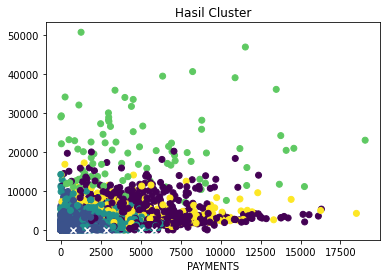

In [12]:
# Plot the predictions.
plt.scatter(X[:,0], X[:,13], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], 
            kmeans.cluster_centers_[:,1], 
            c='w', marker='x', linewidths=2)
plt.xlabel(df.columns[1])
plt.xlabel(df.columns[14])
plt.title('Hasil Cluster')
plt.show()

In [13]:
# We can make new predictions without re-run kmeans (simpily find nearest centroids).
X_new = X[0:5,:] #retrieve rows 0-4
y_pred = kmeans.predict(X_new)

""" The below code is equivalent to:
y_pred = KMeans(...).fit_predict(X), but this needs to fit kmeans again.
"""

display(y_pred)

array([1, 0, 2, 2, 1], dtype=int32)

In [14]:
# We can get distances from data point to every centroid

""" The below code is equivalent to:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distances(X_new, kmeans.cluster_centers_)
"""

kmeans.transform(X_new)

array([[12195.11092154,  1591.29435716,  5783.24600687, 29263.91553553,
        12239.50692123],
       [ 3532.39959214,  8773.61256935,  6534.04912678, 23674.27881133,
         8780.63404179],
       [ 7719.61545158,  5765.32055759,  2156.32914615, 26003.73545523,
         6102.19232757],
       [ 8392.93701338,  5818.63113986,  2470.51438567, 26002.2708986 ,
         6097.58878757],
       [11558.13887982,  1149.77985826,  5347.31668137, 28769.75932772,
        11815.70893823]])

### A Smarter Way to Initialize Centroids: K-means++
Since *K-means* highly depends on the initialization of the centroids, the clustering results may be converged to a local minimum. We can address this by setting `init='kmeans++'` instead of `'random'`. *K-means++* initializes centroids in a smarter way to speed up convergence. The algorithm is as follows:
1. Randomly choose one centroid from the data points.
2. For each data point $x_i$, compute the distance $D(x_i, c_j)$ where $c_j$ is nearest to $x_i$.
3. Randomly choose one new data point as a new centroid using *weighted probability distribution* proportional to $D(x_i, c_j)^2$.
4. Repeat steps 2 and 3 until $k$ centroids have been chosen.
5. Now we have initialized centroids, run *K-means* algorithm.

In [15]:
# Perform K-means++ on our data.
kmeans_plus_plus = KMeans(n_clusters=5,
                n_init=3,
                init='k-means++',
                tol=1e-4, 
                random_state=170,
                verbose=True).fit(X)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 154449886954.65137
start iteration
done sorting
end inner loop
Iteration 1, inertia 149483943790.1409
start iteration
done sorting
end inner loop
Iteration 2, inertia 146450773046.22385
start iteration
done sorting
end inner loop
Iteration 3, inertia 144760422319.83694
start iteration
done sorting
end inner loop
Iteration 4, inertia 143984461677.75522
start iteration
done sorting
end inner loop
Iteration 5, inertia 143482780717.22897
start iteration
done sorting
end inner loop
Iteration 6, inertia 143106906714.93387
start iteration
done sorting
end inner loop
Iteration 7, inertia 142808982299.08588
start iteration
done sorting
end inner loop
Iteration 8, inertia 142628965312.08414
start iteration
done sorting
end inner loop
Iteration 9, inertia 142572013219.12668
start iteration
done sorting
end inner loop
Iteration 10, inertia 142540437069.17462
start iteration
done sorting
end inner loop
Iteratio

You can see that *K-means++* converges much faster than *K-means*!

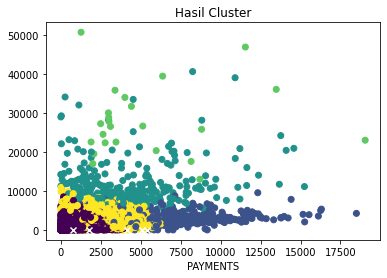

In [16]:
# Plot the predictions.
plt.scatter(X[:,0], X[:,13], c=kmeans_plus_plus.labels_)
plt.scatter(kmeans_plus_plus.cluster_centers_[:,0], 
            kmeans_plus_plus.cluster_centers_[:,1], 
            c='w', marker='x', linewidths=2)
plt.xlabel(df.columns[1])
plt.xlabel(df.columns[14])
plt.title('Hasil Cluster')
plt.show()

## Drawbacks of K-means

### Drawback 1: Need to choose a right number of clusters

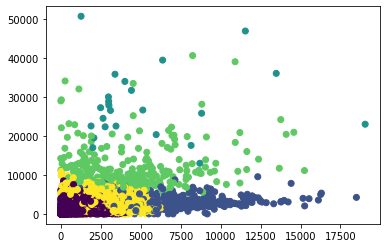

In [17]:
# Run k-means on non-spherical data.
y_pred = KMeans(n_clusters=5, random_state=170).fit_predict(X)

# Plot the predictions.
plt.scatter(X[:,0], X[:,13], c=y_pred)

### Solution: Measuring Cluster Quality to Determine the Number of Clusters


#### Supervised method
*Homogeneity*: Each cluster contains only members of a single class.

*Completeness*: All members of a given class are assigned to the same cluster.

#### Unsupervised method

*Sihouette Coefficient*: Evaluate how well the **compactness** and the **separation** of the clusters are.
(Note that the notation below is consistent with the above content.) Using *Sihouette Coefficient*, we can choose an optimal value for number of clusters.

***

$ a(x_i) $ denotes the **mean intra-cluster distance**. Evaluate the compactness of the cluster to which $x_i$ belongs. (The smaller the more compact)

$$ a(x_i) = \frac{ \sum_{x_k \in C_j ,\ k \neq i}{D(x_i, x_k)} }{\left\vert C_j \right\vert - 1} $$  

For the data point $x_i$, caculate its average distance to all the other data points in its cluster. (Minusing one in denominator part is to leave out the current data point $x_i$)

***

$ b(x_i) $ denotes the **mean nearest-cluster distance**. Evaluate how $x_i$ is separated from other clusters. (The larger the more separated)

$$ b(x_i) = \min_{C_j :\ 1 \leq j \leq k ,\ x_i \notin C_j} \left\{ \frac{ \sum_{x_k \in C_j}{D(x_i, x_k)} }{\left\vert C_j \right\vert } \right\} $$

For the data point $x_i$ and all the other clusters not containing $x_i$, caculate its average distance to all the other data points in the given clusters. Find the minimum distance value with respect to the given clusters. 

***

Finally, *Silhouette Coefficient*: $ s(x_i) = \displaystyle\frac{b(x_i) - a(x_i)}{\max\{a(x_i), b(x_i)\}},\ -1 \leq s(x_i) \leq 1 $. Want $a(x_i) \lt b(x_i)$ and $a(x_i) \to 0$ so as to $s(x_i) \to 1$.

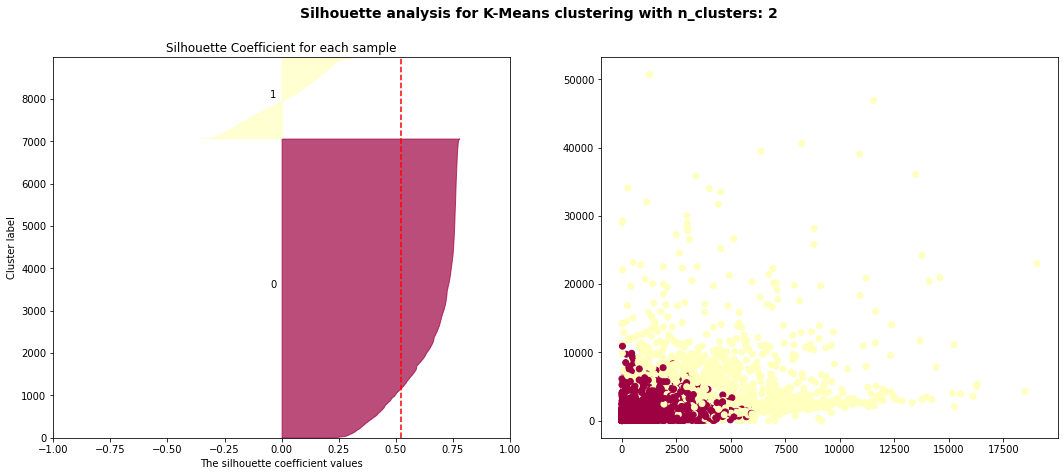

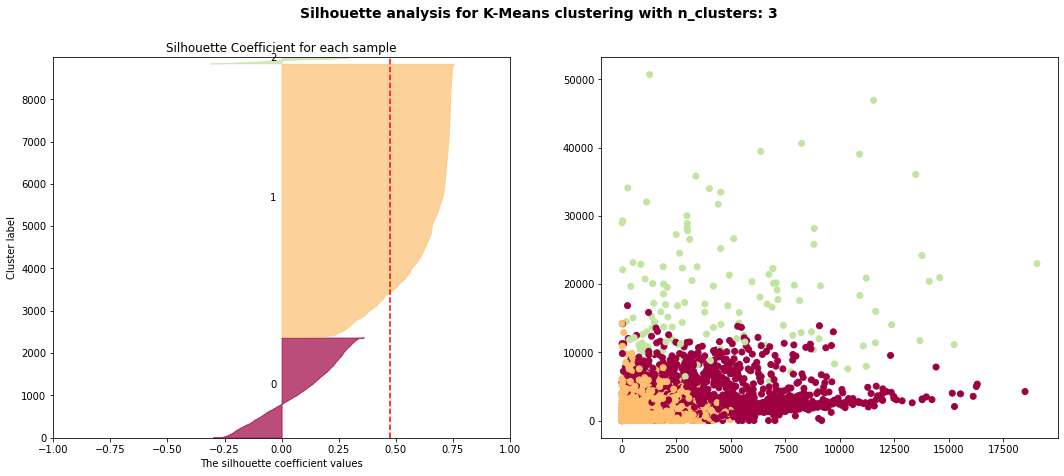

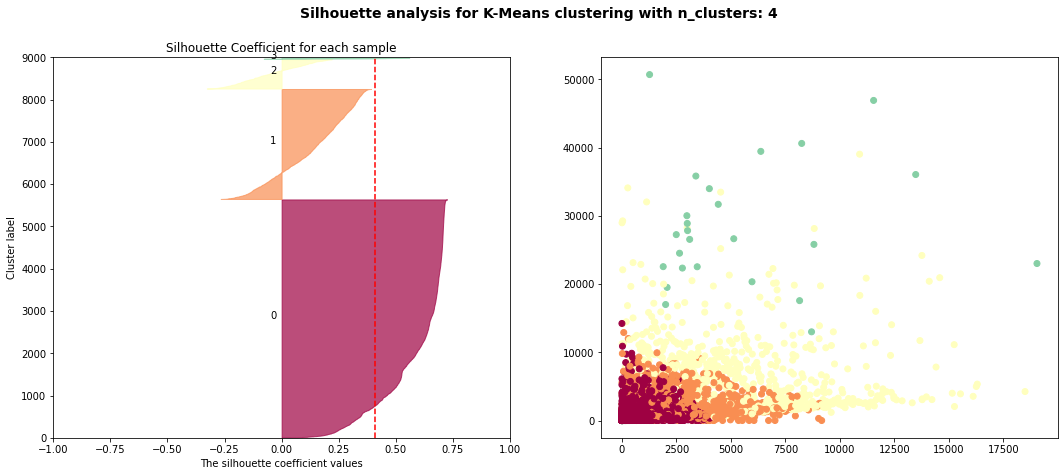

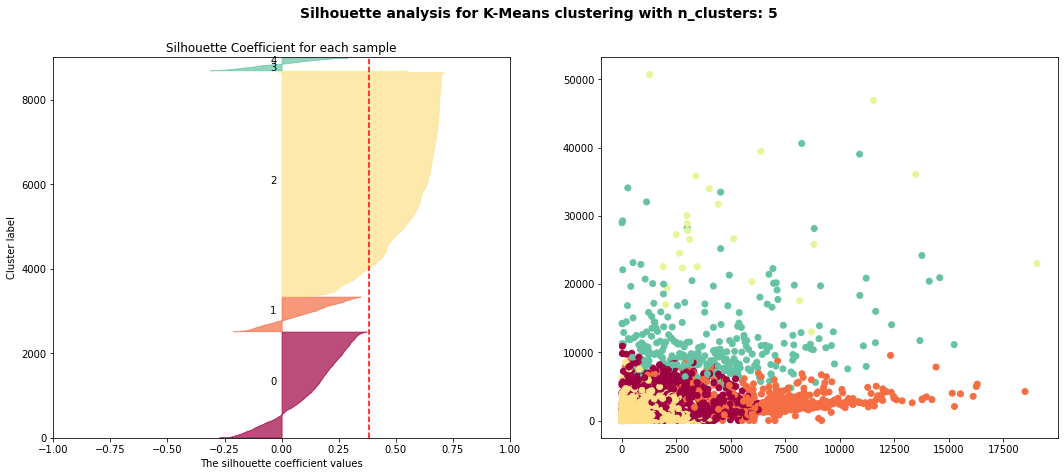

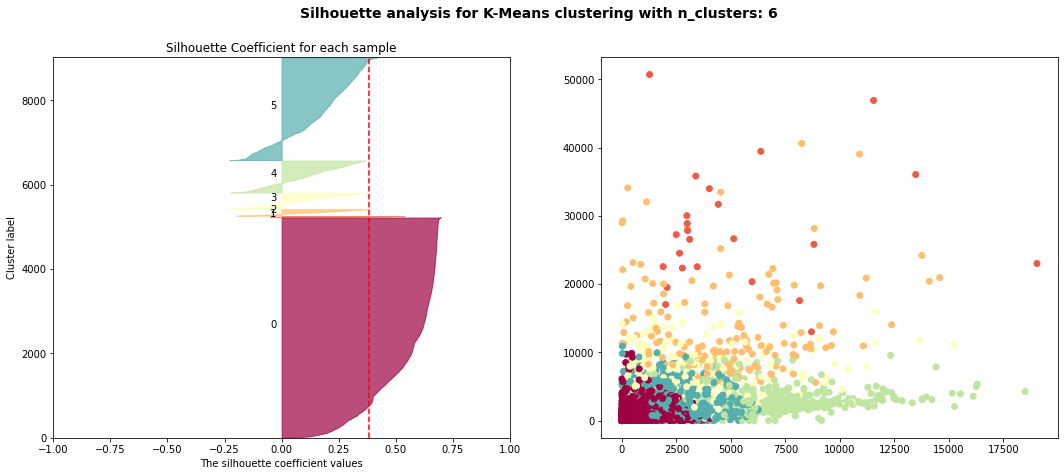

In [18]:
# List of number of clusters
range_n_clusters = [2, 3, 4, 5, 6]

# For each number of clusters, perform Silhouette analysis and visualize the results.
for n_clusters in range_n_clusters:
    
    # Perform k-means.
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    y_pred = kmeans.fit_predict(X)
    
    # Compute the cluster homogeneity and completeness.
    #homogeneity = metrics.homogeneity_score(y, y_pred) (dont have y target)
    #completeness = metrics.completeness_score(y, y_pred) (dont have y target)
    
    # Compute the Silhouette Coefficient for each sample.
    s = metrics.silhouette_samples(X, y_pred)
    
    # Compute the mean Silhouette Coefficient of all data points.
    s_mean = metrics.silhouette_score(X, y_pred)
    
    # For plot configuration -----------------------------------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Configure plot.
    plt.suptitle('Silhouette analysis for K-Means clustering with n_clusters: {}'.format(n_clusters),
                 fontsize=14, fontweight='bold')
    
    # Configure 1st subplot.
    ax1.set_title('Silhouette Coefficient for each sample')
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    # Configure 2st subplot.
    #ax2.set_title('Homogeneity: {}, Completeness: {}, Mean Silhouette score: {}'.format(homogeneity,completeness,s_mean))
    #ax2.set_xlabel("Feature space for the 1st feature")
    #ax2.set_ylabel("Feature space for the 2nd feature")
    
    # For 1st subplot ------------------------------------------------------------------------------------------
    
    # Plot Silhouette Coefficient for each sample
    y_lower = 10
    for i in range(n_clusters):
        ith_s = s[y_pred == i]
        ith_s.sort()
        size_cluster_i = ith_s.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_s,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        
    # Plot the mean Silhouette Coefficient using red vertical dash line.
    ax1.axvline(x=s_mean, color="red", linestyle="--")
    
    # For 2st subplot -------------------------------------------------------------------------------------------
    
    # Plot the predictions
    colors = cmap(y_pred.astype(float) / n_clusters)
    ax2.scatter(X[:,0], X[:,13], c=colors)

The silhouette plot shows that the `n_clusters` value of 3, 5 and 6 are a bad pick for the given data due to the presence of clusters with above average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 4.

### Drawback 2: Cannot handle noise data and outliers

Even noise data and outliers are easily observed from the following clustering results (the data points which are relatively far away from the centroids), *K-means* still puts them into the clusters.

### Solution: Use Distance Threshold to Detect Noise data and Outliers

However, we can detect the noises/outliers conditioning on whether the distance between the data point $x_i$ and the centroid $c_j$ of $x_i$'s corresponding cluster is larger than the average distance in the cluster. That is to say:

$$
\begin{equation}
  x_i=\left\{
  \begin{array}{@{}ll@{}}
    \text{Outlier}, & \text{if}\ D(x_i, c_j) \gt \frac{1}{\left\vert Cluster_j \right\vert} \sum_{k=0,\ k \neq i}^{\left\vert Cluster_j \right\vert}{D(x_k,c_j)} \\
    \text{Non-outlier}, & \text{otherwise}
  \end{array}\right.
  \text{where } c_j \in Cluster_j
\end{equation}
$$

Let's begin to find out the outliers of each cluster. 

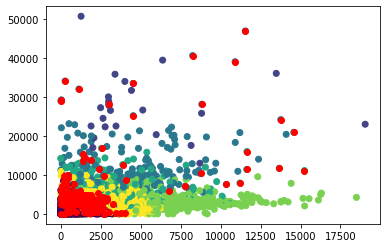

In [19]:
# Ratio for our distance threshold, controlling how many outliers we want to detect.
distance_threshold_ratio = 2.0

# Plot the prediction same as the above.
plt.scatter(X[:,0], X[:,13], c=y_pred)

# For each ith cluster, i=0~3 (we have 4 clusters in this example).
for i in [0, 1, 2, 3]:
    
    # Retrieve the indexs of data points belong to the ith cluster.
    # Note: `np.where()` wraps indexs in a tuple, thus we retrieve indexs using `tuple[0]`
    indexs_of_X_in_ith_cluster = np.where(y_pred == i)[0]

    # Retrieve the data points by the indexs
    X_in_ith_cluster = X[indexs_of_X_in_ith_cluster]
    
    # Retrieve the centroid.
    centroid = kmeans.cluster_centers_[i]
    
    # Compute distances between data points and the centroid.
    # Same as: np.sqrt(np.sum(np.square(X_in_ith_cluster - centroid), axis=1))
    # Note: distances.shape = (X_in_ith_cluster.shape[0], 1). A 2-D matrix.
    #distances = metrics.pairwise.euclidean_distances(X_in_ith_cluster.reshape(-1, 1), centroid.reshape(-1, 1))
    distances = np.zeros((X_in_ith_cluster.shape[0],1))
    for i in range(len(X_in_ith_cluster)):
      distances[i] = np.linalg.norm(X_in_ith_cluster[i] - centroid.reshape(-1,16)) #calculate using norm vector
    
    # Compute the mean distance for ith cluster as our distance threshold.
    distance_threshold = np.mean(distances)
    
    # Retrieve the indexs of outliers in ith cluster
    # Note: distances.flatten() flattens 2-D matrix to vector, in order to compare with scalar `distance_threshold`.
    indexs_of_outlier = np.where(distances.flatten() > distance_threshold * distance_threshold_ratio)[0]
    
    # Retrieve outliers in ith cluster by the indexs
    outliers = X_in_ith_cluster[indexs_of_outlier]
    
    # Plot the outliers in ith cluster.
    plt.scatter(outliers[:,0], outliers[:,13], c='r') #plot for 2D of 16D

As we've mentioned about measuring cluster quality analysis, you can run different settings of `distance_threshold_ratio` to find out the best cluster quality.

### Drawback 3: Cannot handle non-spherical data

> *K-means* clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with **the nearest mean**. (Wikipedia) 

Since the concentric circles would have the approximately same mean, so k-means is not suitable to separate them.

Let's generate non-spherical data and plot the ground truths of clusters.

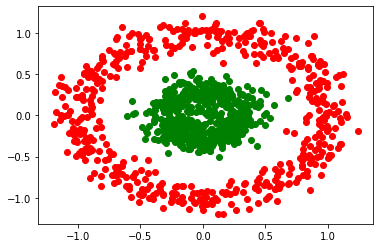

In [20]:
# Generate non-spherical data.
X, y = make_circles(n_samples=1000, factor=0.3, noise=0.1)

# Plot the data distribution. (Here's another way to plot scatter graph)
plt.plot(X[y == 0, 0], X[y == 0, 1], 'ro')
plt.plot(X[y == 1, 0], X[y == 1, 1], 'go')

After performing *K-means* on non-spherical data, the following result shows that it fails to cluster non-spherical data, since *K-means* has an assumption that the data distribution is spherical.

Homogeneity: 0.0006504584566222114
Completeness: 0.0006512874357160269
Mean Silhouette score: 0.28988209971941653


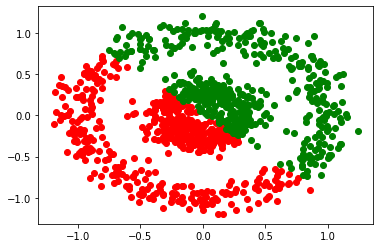

In [21]:
# Run k-means on non-spherical data.
y_pred = KMeans(n_clusters=2, random_state=170).fit_predict(X)

# Plot the predictions.
plt.plot(X[y_pred == 0, 0], X[y_pred == 0, 1], 'ro')
plt.plot(X[y_pred == 1, 0], X[y_pred == 1, 1], 'go')

# Print the evaluations
print('Homogeneity: {}'.format(metrics.homogeneity_score(y, y_pred)))
print('Completeness: {}'.format(metrics.completeness_score(y, y_pred)))
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(X, y_pred)))

### Solution: Using Feature Transformation or Extraction Techiques Makes Data Clusterable

If you know that your clusters will always be concentric circles, you can simply convert your cartesian (x-y) coordinates to polar coordinates, and use only the radius for clustering - as you know that the angle theta doesn't matter.

Or more generally: use a suitable kernel for k-means clustering, e.g. use *Kernel PCA* to find a projection of the data that makes data linearly separable, or use another clustering algorithm, such as *DBSCAN*.

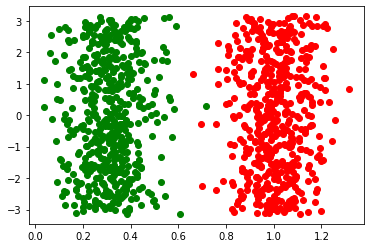

In [22]:
def cart2pol(x, y):
    radius = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return radius, theta

X_transformed = np.zeros_like(X)
X_transformed[:,0], X_transformed[:,1] = cart2pol(X[:,0], X[:,1])

plt.plot(X_transformed[y == 0, 0], X_transformed[y == 0, 1], 'ro')
plt.plot(X_transformed[y == 1, 0], X_transformed[y == 1, 1], 'go')

We just successfully make data linearly separable by converting features (x-y) to (radius-theta) !

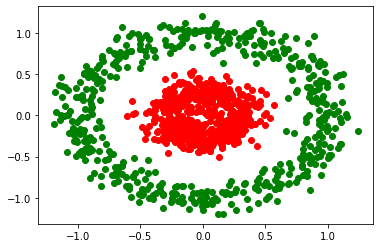

In [23]:
def cart2pol(x, y):
    radius = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return radius, theta

X_transformed = np.zeros_like(X)
# Convert cartesian (x-y) to polar coordinates.
X_transformed[:,0], _ = cart2pol(X[:,0], X[:,1])

# Only use `radius` feature to cluster.
y_pred = KMeans(n_clusters=2).fit_predict(X_transformed)

plt.plot(X[y_pred == 0, 0], X[y_pred == 0, 1], 'ro')
plt.plot(X[y_pred == 1, 0], X[y_pred == 1, 1], 'go')

Now the data is successfully clustered!

### Drawback 4: Cannot to handle categorical data.
Since *k-means* only works when *mean* is defined, categorical data cannot compute mean value.

### Solution: Please refer to https://github.com/nicodv/kmodes

## DBSCAN: Density-Based Spatial Clustering of Applications with Noise

### Parameters
- $Eps$: Maximum radius of the neighborhood.
- $MinPts$: Minimum number of points in the Eps-neighborhood of a point.

### Terms
- The Eps-neighborhood of a point $q$－$N_{Eps}$: A point $p \in N_{Eps}(q)$ if $D(p,q) \leq Eps$. (Point inside the circle).
- Outlier: Not in a cluster.
- Core point: $\left\vert N_{Eps}(q) \right\vert \geq MinPts$ (dense neighborhood).
- Border point: In cluster but neighborhood is not dense.

<div style="text-align:center"><img width="300px" src="../img/core-border-point.png"/></div>


- Directly density-reachable: A point $p$ is **directly density-reachable** from a point $q$ w.r.t $Eps$ and $MinPts$ if:
    - $p \in N_{Eps}(q)$, and $q$ is a **core point**.
    - $p$ **doesn't** need to be a core point.

<div style="text-align:center"><img width="250px" src="../img/directly-density-reachable.png"/></div>

- Density-reachable: A point $p$ is **density-reachable** from a point $q$ w.r.t. $Eps$ and $MinPts$ if there is a chain of points $p_1, \dots, p_n,\ p_1 = q,\ p_n = p$ such that $p_{i+1}$ is directly density-reachable from $p_i$.

<div style="text-align:center"><img width="150px" src="../img/density-reachable.png"/></div>

### The Algorithm
1. Randomly choose a point $p$.
2. Retrieve all points density-reachable from $p$ w.r.t. $Eps$ and $MinPts$.
3. If $p$ is a core point, a cluster is formed.
4. If $p$ is a border point, no points are density-reachable from $p$, then visit the next point.
5. Repeat the process until all the data points have been processed.

Let's begin to perform *DBSCAN* on spherical data

Number of clusters: 10
Mean Silhouette score: -0.3069728450995836


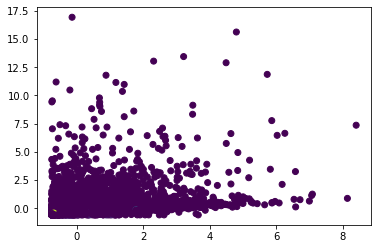

In [24]:
#Define X as Data
X = df.iloc[:,1:].values

# Standardize features to zero mean and unit variance.
X = StandardScaler().fit_transform(X)

# Perform DBSCAN on the data
y_pred = DBSCAN(eps=0.5, min_samples=10).fit_predict(X)

# Plot the predictions
plt.scatter(X[:,0], X[:,13], c=y_pred)

# Print the evaluations
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))
#print('Homogeneity: {}'.format(metrics.homogeneity_score(y, y_pred))) (dont have y target)
#print('Completeness: {}'.format(metrics.completeness_score(y, y_pred))) (dont have y target)
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(X, y_pred)))

The **black** data points denote the **outliers** in the above result.

Note that we don't need to specify the number of clusters with *DBSCAN* algorithm. Besides, *DBSCAN* is good at finding out the outliers without requiring some hacks like we did above in *K-means* section. 

Now, let's try *DBSCAN* on non-spherical data.

Number of clusters: 2
Homogeneity: 1.0
Completeness: 0.9495442147743769
Mean Silhouette score: 0.16466060501909494


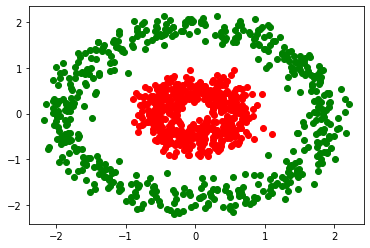

In [25]:
# Generate non-spherical data.
X, y = make_circles(n_samples=1000, factor=0.3, noise=0.1)

# Standardize features to zero mean and unit variance.
X = StandardScaler().fit_transform(X)

# Perform DBSCAN on the data
y_pred = DBSCAN(eps=0.3, min_samples=10).fit_predict(X)

# Plot the data distribution. (Here's another way to plot scatter graph)
plt.plot(X[y_pred == 0, 0], X[y_pred == 0, 1], 'ro')
plt.plot(X[y_pred == 1, 0], X[y_pred == 1, 1], 'go')

# Print the evaluations
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))
print('Homogeneity: {}'.format(metrics.homogeneity_score(y, y_pred)))
print('Completeness: {}'.format(metrics.completeness_score(y, y_pred)))
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(X, y_pred)))

Comparing to *K-means*, we can directly apply *DBSCAN* on this form of data distribution due to the density-based clustering criterion.

Note: It's worth mention that the *Silhouette score* is generally higher for **convex** clusters than other concepts of clusters, such as density based clusters.

#### References
The tutorial mainly refers to the following resources:
- [scikit-learn](http://scikit-learn.org/)
- [How to understand the drawbacks of K-means](http://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means)
- [The Sihouette Coefficient](https://cs.fit.edu/~pkc/classes/ml-internet/silhouette.pdf)
- [Cluster Analysis in Data Mining tutorial video series](https://www.youtube.com/watch?v=uRwzqDeAwfk&index=42&list=PL04RENt_K5EvbBl9rJEy-7D-IAFqPYrMt)
- [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN)